# Apr 13th, 2022 (node & oc overlap scores)

**Motivation**: Pie -> bar for oces, and lots of supplementary figs <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(_fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

_CA = r'Ca$^{2\!+}$'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_CA: mako(0.6), 'BOLD': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

## Overlap score

In [5]:
ovp_b = ovp_score(gr_bold.run_pi_prune, 0.1)
ovp_c = ovp_score(gr_ca.run_pi_prune, 0.1)
ovp_b, ovp_c

(
    {
        'se_oc': array([3.17419926, 4.28943408, 3.49708958, 4.0657429 , 3.83740538]),
        'se_node': array([2.76359612, 1.43877379, 1.14939727, 0.49479272, 0.42313621]),
        'score_oc': array([59.24509242, 55.66712799, 48.89930116, 74.38780397, 83.11583035]),
        'score_node': array([56.19049651, 31.89486261,  8.22585937,  2.36154717,  1.32723434])
    },
    {
        'se_oc': array([4.25657601, 4.06571818, 3.39527664, 3.01526751, 2.91205644]),
        'se_node': array([1.93915789, 1.47454057, 1.12999464, 0.30251907, 0.24174394]),
        'score_oc': array([62.48182409, 71.82878795, 72.684731  , 80.69596685, 74.19476474]),
        'score_node': array([45.67661314, 40.01852311, 11.63812078,  1.80285943,  0.86388355])
    }
)

In [6]:
save_dir = pjoin(fig_dir, 'overlap_score')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper/overlap_score'

### Plot: score OC

In [7]:
dlist = []
for i in range(5):
    dlist.append({
        'oc': [i + 1] * 2,
        'mode': ['bold', 'ca2'],
        'score': [ovp_b['score_oc'][i], ovp_c['score_oc'][i]],
        'se': [ovp_b['se_oc'][i], ovp_c['se_oc'][i]],
    })
df = pd.DataFrame(merge_dicts(dlist))

In [8]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)
tval

2.2621571627409915

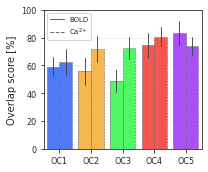

In [9]:
fig, ax = create_figure(figsize=(3, 2.5))
sns.barplot(
    data=df,
    x='oc',
    y='score',
    hue='mode',
    dodge=True,
    # capsize=0,
    ax=ax
)

# Fix colors
palette = get_cluster_cmap(range(5), return_colors=True)[1]
palette = np.tile(palette, 2)
for i, (r, c) in enumerate(zip(ax.get_children()[:10], palette)):
    r.set_facecolor(c)
    r.set_alpha(0.9)
    r.set_edgecolor('dimgrey')
    r.set_linestyle('-' if i // 5 == 0 else '--')
    r.set_linewidth(0.6)

# Fix error bars
lines = ax.get_lines()
for i in range(5):
    mu, se = df.loc[df['mode'] == 'bold', ['score', 'se']].iloc[i]
    a = mu - tval * se
    b = mu + tval * se
    lines[i].set_ydata([a, b])
    
    mu, se = df.loc[df['mode'] == 'ca2', ['score', 'se']].iloc[i]
    a = mu - tval * se
    b = mu + tval * se
    lines[i + 5].set_ydata([a, b])
for ll in lines:
    ll.set_linewidth(9/10)
    
ax.legend().remove()
ax.set_ylim(0, 100)
ax.grid(axis='y', ls='-', alpha=0.3)
ax.set_xlabel('')
ax.set_ylabel('Overlap score [%]', fontsize=10)
ax.set_xticklabels([f'OC{i}' for i in range(1, 5 + 1)])
ax.tick_params(axis='both', labelsize=8)

legend_elements = [
    Line2D([0], [0], color='dimgrey', lw=1.0, ls='-', label='BOLD'),
    Line2D([0], [0], color='dimgrey', lw=1.0, ls='--', label=_CA),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=7)

name = 'OCs-bar'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)

plt.show()

### Plot: score Node

In [10]:
dlist = []
for i in range(5):
    dlist.append({
        'oc': [i + 1] * 2,
        'mode': ['BOLD', _CA],
        'score': [ovp_b['score_node'][i], ovp_c['score_node'][i]],
        'se': [ovp_b['se_node'][i], ovp_c['se_node'][i]],
    })
df = pd.DataFrame(merge_dicts(dlist))

In [11]:
ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)
tval

2.2621571627409915

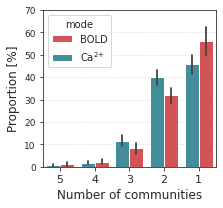

In [12]:
fig, ax = create_figure(figsize=(3.2, 3))
sns.barplot(
    data=df,
    x='oc',
    y='score',
    hue='mode',
    palette=pal,
    ci='sd',
    ax=ax,
)
lines = ax.get_lines()
for i in range(5):
    mu, se = df.loc[df['mode'] == 'BOLD', ['score', 'se']].iloc[i].values
    a = mu - tval * se
    b = mu + tval * se
    lines[i].set_ydata([a, b])
    
    mu, se = df.loc[df['mode'] == _CA, ['score', 'se']].iloc[i].values
    a = mu - tval * se
    b = mu + tval * se
    lines[i + 5].set_ydata([a, b])

for ll in lines:
    ll.set_linewidth(18/10)

ax.set_ylim(0, 70)
# ax.set_xticklabels([f'C = {i + 1}' for i in range(5)])
ax.tick_params(axis='y', labelsize=9)
ax.tick_params(axis='x', labelsize=11)
ax.set_xlabel('Number of communities', fontsize=12)
# ax.set_xlabel('')
ax.set_ylabel('Proportion [%]', fontsize=12)
ax.invert_xaxis()
ax.grid(axis='y')

name = 'Nodes-bar'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)

plt.show()

### Plot: pie nodes

In [13]:
disj_b, disj_c = df.loc[df['oc'] == 1, 'score'].values
disj_b, disj_c

(56.19049650965062, 45.67661314312481)

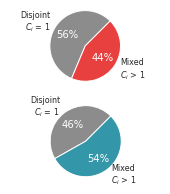

In [14]:
grey = list(sns.color_palette('deep'))[-3]
fig, axes = create_figure(2, 1, (2.8, 3.2), tight_layout=False, constrained_layout=False)

labels = ['Disjoint\n' + r'$C_i$ = 1', 'Mixed\n' + r'$C_i$ > 1']

*_, autotexts = axes[0].pie(
    x=[disj_b, 100 - disj_b],
    labels=labels,
    explode=(0, 0),
    autopct='%1.0f%%',
    shadow=False,
    startangle=45,
    labeldistance=1.2,
    colors=[grey, pal['BOLD']],
    textprops={'fontsize': 8},
)
_ = [t.set_fontsize(10) for t in autotexts]
_ = [t.set_color('white') for t in autotexts]
# axes[0].set_title('Bold', fontsize=22)
axes[0].axis('equal')

*_, autotexts = axes[1].pie(
    x=[disj_c, 100 - disj_c],
    labels=labels,
    explode=(0, 0),
    autopct='%1.0f%%',
    shadow=False,
    startangle=45,
    labeldistance=1.2,
    colors=[grey, pal[_CA]],
    textprops={'fontsize': 8},
)
_ = [t.set_fontsize(10) for t in autotexts]
_ = [t.set_color('white') for t in autotexts]
# axes[1].set_title(r'Ca$^{2+}$', fontsize=22)
axes[1].axis('equal')

name = f'Nodes-pie'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), bbox_inches='tight')
plt.show()

## Loop d, K, th

In [15]:
%%time

ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)
dlist = []
for d in [10, 20]:
    _props_b = props_bold.copy()
    _props_c = props_ca.copy()
    _props_b['perc'] = f"p{d}-sample"
    _props_c['perc'] = f"p{d}-sample"
    for i, k in enumerate(range(3, 10)):
        _props_b['num_k'] = k
        _props_c['num_k'] = k
        try:
            _gr_c = Group(**_props_c).fit_group()
            _gr_b = Group(**_props_b).fit_group()
        except ValueError:
            continue
            
        good_nodes = np.logical_and(
            np.isnan(_gr_b.grp_pi_prune).sum(0) == 0,
            np.isnan(_gr_c.grp_pi_prune).sum(0) == 0,
        )
        sim = dist2sim(sp_dist.cdist(
            XA=_gr_b.grp_pi[:, good_nodes],
            XB=_gr_c.grp_pi[:, good_nodes],
            metric='cosine',
        ))
        mapping = find_best_match(sim)
        ids = list(mapping.values())
        _gr_b.pi = _gr_b.grp_pi
        _gr_c.pi = _gr_c.grp_pi[ids]
        
        thresholds = [0.10, 0.15, 0.20]
        if 1 / k not in thresholds:
            thresholds.append(1 / k)
        for th in sorted(thresholds):
            ovp_b = ovp_score(_gr_b.run_pi_prune, thres=th)
            ovp_c = ovp_score(_gr_c.run_pi_prune, thres=th)
            for i in range(k):
                score = [ovp_b['score_oc'][i], ovp_c['score_oc'][i]]
                se = [ovp_b['se_oc'][i], ovp_c['se_oc'][i]]
                dlist.append({
                    'd': [d] * 2,
                    'K': [k] * 2,
                    'th': [th] * 2,
                    'oc': [i + 1] * 2,
                    'mode': ['bold', 'ca2'],
                    'label': ['community'] * 2,
                    'lo': [score[0] - tval * se[0], score[1] - tval * se[1]],
                    'hi': [score[0] + tval * se[0], score[1] + tval * se[1]],
                    'score': score,
                    'se': se,
                })
                score = [ovp_b['score_node'][i], ovp_c['score_node'][i]]
                se = [ovp_b['se_node'][i], ovp_c['se_node'][i]]
                dlist.append({
                    'd': [d] * 2,
                    'K': [k] * 2,
                    'th': [th] * 2,
                    'oc': [i + 1] * 2,
                    'mode': ['bold', 'ca2'],
                    'label': ['node'] * 2,
                    'lo': [score[0] - tval * se[0], score[1] - tval * se[1]],
                    'hi': [score[0] + tval * se[0], score[1] + tval * se[1]],
                    'score': score,
                    'se': se,
                })
df = pd.DataFrame(merge_dicts(dlist))
df_avg = df.loc[df['label'] == 'community']
df_avg = df_avg.groupby(['d', 'K', 'th', 'mode'])
df_avg = df_avg.mean().reset_index().drop(columns=['oc'])

CPU times: user 8min 51s, sys: 32.2 s, total: 9min 24s
Wall time: 9min 24s


In [16]:
save_dir = pjoin(fig_dir, 'overlap_score', 'tmp')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper/overlap_score/tmp'

### TMP plot: OCs

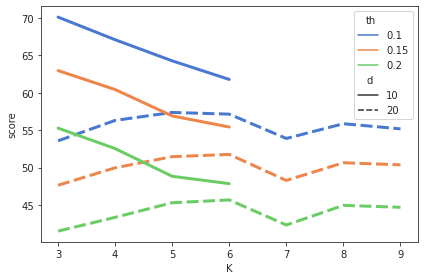

In [17]:
_df = df_avg.loc[
    (df_avg['mode'] == 'bold') &
    (df_avg['th'].isin([0.10, 0.15, 0.20]))
]
fig, ax = create_figure()
sns.lineplot(
    data=_df,
    x='K',
    y='score',
    hue='th',
    palette='muted',
    style='d',
    lw=3,
    ax=ax,
)
name = 'threshold-dependence'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
plt.show()

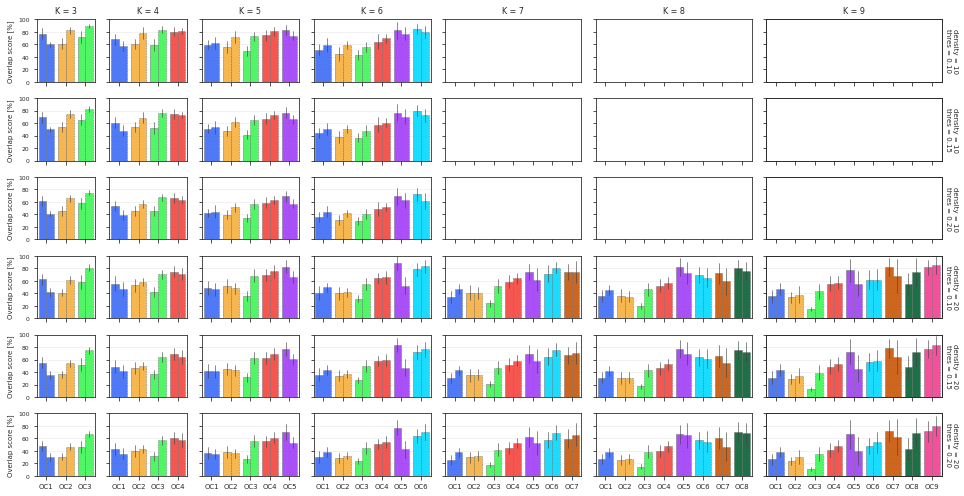

In [18]:
fig, axes = create_figure(6, 7, (13.5, 7), 'col', 'all', width_ratios=np.linspace(1, 3, 7))

for i1, d in enumerate([10, 20]):
    for i2, th in enumerate([0.10, 0.15, 0.20]):
        for j, k in enumerate(df['K'].unique()):
            i3 = i1 * 3 + i2
            ax = axes[i3, j]
            if i3 == 0:
                ax.set_title(f'K = {k}', fontsize=8)
            if k == df['K'].max():
                axtw = ax.twinx()
                lbl = f"density = {d:0d}\nthres = {th:0.2f}"
                axtw.set_ylabel(lbl, rotation=-90, fontsize=7, labelpad=16)
                axtw.set_yticks([])

            _df = df.loc[
                (df['d'] == d) &
                (df['K'] == k) &
                (df['th'] == th) &
                (df['label'] == 'community')
            ]
            if not len(_df):
                continue

            sns.barplot(
                data=_df,
                x='oc',
                y='score',
                hue='mode',
                dodge=True,
                # capsize=0,
                ax=ax
            )
            # Fix colors
            palette = get_cluster_cmap(range(k), return_colors=True)[1]
            palette = np.tile(palette, 2)
            for i, (r, c) in enumerate(zip(ax.get_children()[:2*k], palette)):
                r.set_facecolor(c)
                r.set_alpha(0.9)
                r.set_edgecolor('dimgrey')
                r.set_linestyle('-' if i // k == 0 else '--')
                r.set_linewidth(0.5)

            # Fix error bars
            lines = ax.get_lines()
            for i in range(k):
                mu, se = _df.loc[_df['mode'] == 'bold', ['score', 'se']].iloc[i]
                a = mu - tval * se
                b = mu + tval * se
                lines[i].set_ydata([a, b])

                mu, se = _df.loc[_df['mode'] == 'ca2', ['score', 'se']].iloc[i]
                a = mu - tval * se
                b = mu + tval * se
                lines[i + k].set_ydata([a, b])
            for ll in lines:
                ll.set_linewidth(6/10)
            
            if j == 0:
                ax.set_ylabel('Overlap score [%]', fontsize=7)
            else:
                ax.set_ylabel('')

            ax.legend().remove()
            ax.set_ylim(0, 100)
            ax.grid(axis='y', ls='-', alpha=0.3)
            ax.set_xlabel('')
            ax.set_xticklabels([f'OC{i}' for i in range(1, k + 1)])
            ax.tick_params(axis='x', labelsize=7)
            ax.tick_params(axis='y', labelsize=6)

            # legend_elements = [
            #     Line2D([0], [0], color='dimgrey', lw=1.0, ls='-', label='BOLD'),
            #     Line2D([0], [0], color='dimgrey', lw=1.0, ls='--', label=r'Ca$^{2\!\!+}$'),
            # ]
            # ax.legend(handles=legend_elements, loc='upper left', fontsize=7)
name = 'ovpscore-bar-dependence'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
plt.show()

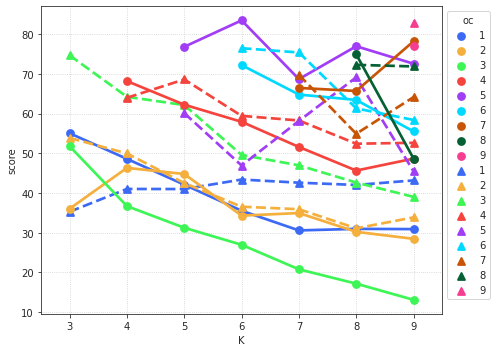

In [19]:
palette = get_cluster_cmap(range(9), return_colors=True)[1]
fig, ax = create_figure(figsize=(7, 5))

_df = df.loc[
    (df['d'] == 20) &
    (df['th'] == 0.15) &
    (df['mode'] == 'bold') &
    (df['label'] == 'community')
]
sns.pointplot(
    data=_df,
    x='K',
    y='score',
    hue='oc',
    linestyles='-',
    markers='o',
    palette=palette,
    ax=ax,
)
_df = df.loc[
    (df['d'] == 20) &
    (df['th'] == 0.15) &
    (df['mode'] == 'ca2') &
    (df['label'] == 'community')
]
sns.pointplot(
    data=_df,
    x='K',
    y='score',
    hue='oc',
    linestyles='--',
    markers='^',
    palette=get_cluster_cmap(range(9), return_colors=True)[1],
    ax=ax,
)
# ax.axvspan(1.5, 2.5, color='dimgrey', alpha=0.1, zorder=0)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 1))
ax.grid()
name = 'ovpscore-pt-dependence'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
plt.show()

### TMP plot: nodes

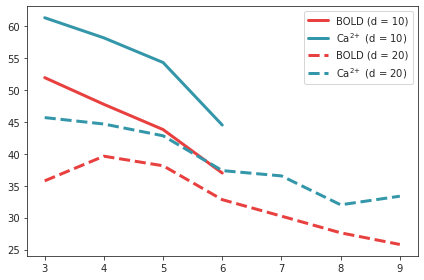

In [68]:
th = 0.1
b_all = collections.defaultdict(dict)
c_all = collections.defaultdict(dict)
for d in [10, 20]:
    for k in df['K'].unique():
        try:
            disj_b, disj_c = df.loc[
                (df['label'] == 'node') &
                (df['oc'] == 1) &
                (df['d'] == d) &
                (df['K'] == k) &
                (df['th'] == th),
                'score'
            ].values
        except ValueError:
            disj_b, disj_c = np.nan, np.nan
        b_all[d][k] = 100 - disj_b
        c_all[d][k] = 100 - disj_c
        
fig, ax = create_figure()
for d, ls in {10: '-', 20: '--'}.items():
    ax.plot(b_all[d].keys(), b_all[d].values(), ls=ls, lw=3, color=pal['BOLD'], label=f'BOLD (d = {d})')
    ax.plot(c_all[d].keys(), c_all[d].values(), ls=ls, lw=3, color=pal[_CA], label=f'{_CA} (d = {d})')
ax.legend()
plt.show()

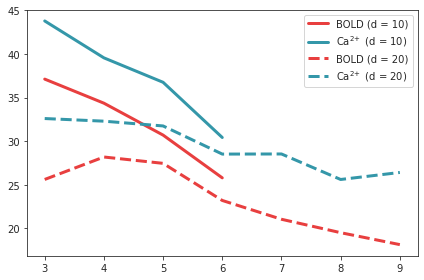

In [69]:
th = 0.2
b_all = collections.defaultdict(dict)
c_all = collections.defaultdict(dict)
for d in [10, 20]:
    for k in df['K'].unique():
        try:
            disj_b, disj_c = df.loc[
                (df['label'] == 'node') &
                (df['oc'] == 1) &
                (df['d'] == d) &
                (df['K'] == k) &
                (df['th'] == th),
                'score'
            ].values
        except ValueError:
            disj_b, disj_c = np.nan, np.nan
        b_all[d][k] = 100 - disj_b
        c_all[d][k] = 100 - disj_c
        
fig, ax = create_figure()
for d, ls in {10: '-', 20: '--'}.items():
    ax.plot(b_all[d].keys(), b_all[d].values(), ls=ls, lw=3, color=pal['BOLD'], label=f'BOLD (d = {d})')
    ax.plot(c_all[d].keys(), c_all[d].values(), ls=ls, lw=3, color=pal[_CA], label=f'{_CA} (d = {d})')
ax.legend()
plt.show()

In [67]:
1 / 8

0.125